This is an illustrative example of a Pairs Trading involving Coca-Cola (KO) and PepsiCo (PEP), despite being fundamentaly different companies, for example, KO has half the sales of PEP but has a higher Net Income however they both manufacture, distribute and sell soft beverages.

But the market already knows past information if any new information is released, specially if affects both companies like for example new regulations affecting the beverage market, its expected that it will affect both companies in the same way therefore the price of each should move in the same direction.

This strategy falls under the expectation that when prices depart from their historic equilibrium (quantified here as rolling correlation), the company that valued less in the last week will catchup during the trade session, being the positions open at open price (slippage & transaction costs can be factored in but aren't accounted for) and sold at close

In [115]:
# python 3.7

# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import datetime
import calendar
# Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# Assets under consideration
tickers = ['PEP','KO']
#tickers = ["UPWK", "FVRR"]
#tickers = ["INTC", "AMD"]
#tickers = ["NVDA", "AMD"]
data = None
while data is None:
    try:
        data = getdata(tickers,'946685000',str(calendar.timegm(datetime.datetime.now().timetuple())),'1d')
    except:
         pass
        
df1 = data[tickers[0]]
df2 = data[tickers[1]]

In [116]:
#handle different IPO dates
if len(df1)<len(df2):
    df2=df2.loc[df1.index]
elif len(df1)>len(df2):
    df1=df1.loc[df2.index]

In [117]:
#tc = -0.0005 # Transaction costs

pairs = pd.DataFrame({'TPEP':df1['Close'].shift(1)/df1['Close'].shift(2)-1,
                      'TKO':df2['Close'].shift(1)/df2['Close'].shift(2)-1})

# Criteria to select which asset we're gonna buy, in this case, the one that had the lowest return yesterday
pairs['Target'] = pairs.min(axis=1)

# Signal that triggers the purchase of the asset
pairs['Correlation'] = ((df1['Close'].shift(1)/df1['Close'].shift(20)-1).rolling(window=9)
                        .corr((df2['Close'].shift(1)/df2['Close'].shift(20)-1)))

Signal = pairs['Correlation'] < 0.9

# We're holding positions that weren't profitable yesterday
HoldingYesterdayPosition = ((pairs['Target'].shift(1).isin(pairs['TPEP']) &
                             (df1['Close'].shift(1)/df1['Open'].shift(1)-1 < 0)) |
                            (pairs['Target'].shift(1).isin(pairs['TKO']) &
                             (df2['Close'].shift(1)/df2['Open'].shift(1)-1 < 0))) # if tc, add here

# Since we aren't using leverage, we can't enter on a new position if
# we entered on a position yesterday (and if it wasn't profitable)
NoMoney = Signal.shift(1) & HoldingYesterdayPosition

pairs[tickers[0]] = np.where(NoMoney,
                        np.nan,
                        np.where(df1['Close']/df1['Open']-1 < 0,
                                 df1['Close'].shift(-1)/df1['Open']-1,
                                 df1['Close']/df1['Open']-1))

pairs[tickers[1]] = np.where(NoMoney,
                       np.nan,
                       np.where(df2['Close']/df2['Open']-1 < 0,
                                df2['Close'].shift(-1)/df2['Open']-1,
                                df2['Close']/df2['Open']-1))

pairs['Returns'] = np.where(Signal,
                            np.where(pairs['Target'].isin(pairs['TPEP']),
                                      pairs[tickers[0]],
                                      pairs[tickers[1]]),
                             np.nan) # if tc, add here

pairs['CumulativeReturn'] = pairs['Returns'].dropna().cumsum()

In [118]:
pairs

,TPEP,TKO,Target,Correlation,PEP,KO,Returns,CumulativeReturn
Date,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,0.042403,-0.026940,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,-0.041026,0.001109,NaN,NaN
2000-01-05,-0.025424,0.001109,-0.025424,NaN,0.022688,0.008859,NaN,NaN
2000-01-06,-0.024348,0.008859,-0.024348,NaN,0.053957,0.001098,NaN,NaN
2000-01-07,0.044563,0.001098,0.001098,NaN,0.020339,0.049676,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-21,0.012377,0.008861,0.008861,0.936988,-0.000135,0.000000,NaN,NaN
2021-05-24,-0.000883,-0.000549,-0.000883,0.936360,0.001422,0.003112,NaN,NaN
2021-05-25,0.005099,0.003295,0.003295,0.935439,0.003044,0.003831,NaN,NaN


In [119]:
# Pepsi returns
ReturnPEP = df1['Close']/df1['Open']-1
BuyHoldPEP = df1['Adj Close']/float(df1['Adj Close'][:1])-1

# Coca Cola returns
ReturnKO = df2['Close']/df2['Open']-1
BuyHoldKO = df2['Adj Close']/float(df2['Adj Close'][:1])-1

# Benchmark
ReturnBoth = (ReturnPEP+ReturnKO)/2
BuyHoldBoth = ((BuyHoldPEP+BuyHoldKO)/2).fillna(method='ffill')

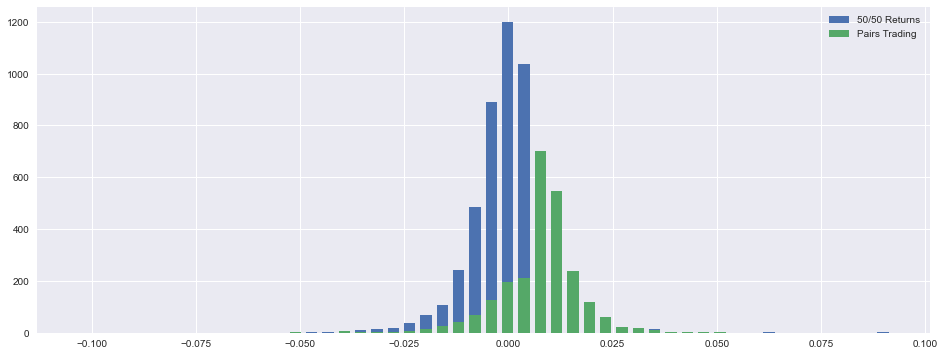

=====Strategy Returns=====
Mean return = 0.14 %
Standard deviaton = 1.36 %
Worst return = -14.41 %
Best return = 11.08 %
Lower quantile = -0.4 %
Median return = 0.26 %
Upper quantile = 0.73 %


In [120]:
returns = pairs['Returns'].dropna()
cumulret = pairs['CumulativeReturn'].dropna()

fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(ReturnBoth.dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

ax.bar(center, hist1, align='center', width=width, label='50/50 Returns')

hist2, bins2 = np.histogram(returns, bins=50)
ax.bar(center, hist2, align='center', width=width, label='Pairs Trading')

plt.legend()
plt.show()

print('=====Strategy Returns=====')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("==========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [121]:
# Some stats, this could be improved by trying to estimate a yearly sharpe, among many others
executionrate = len(returns)/len(ReturnBoth)

maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1) 
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)

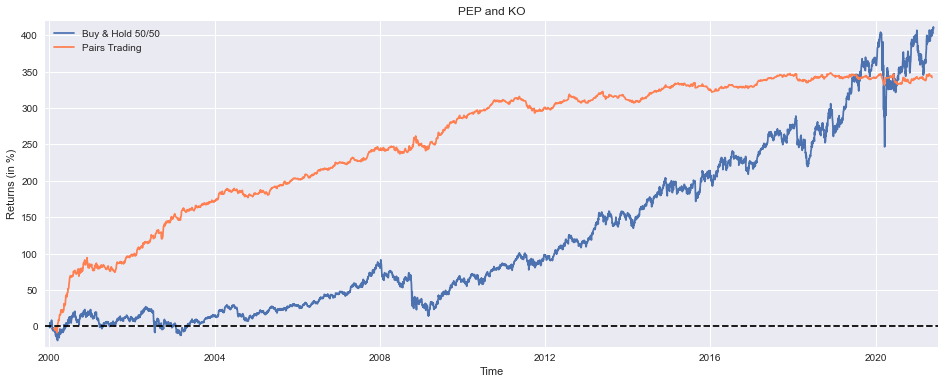

Cumulative Return =  342.11 %
Execution Rate =  45.46 %
Win Rate =  67.98 %
Maximum Loss =  22.5 %
Maximum Consecutive Loss =  15.49 %
Beta =  0.63
Sharpe =  3.83


In [122]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50')
plt.plot(cumulret*100, label='Pairs Trading', color='coral')
plt.title(" and ".join(tickers))
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",round(executionrate*100,2),"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)
# Return ("alpha") decay is pretty noticeable from 2011 onwards, most likely due to overfitting, they're not reinvested

In [113]:
subset=df1.index>=datetime.datetime.now().replace(month=1,day=1)
returns_ytd_slice=returns.index>=datetime.datetime.now().replace(month=1,day=1)

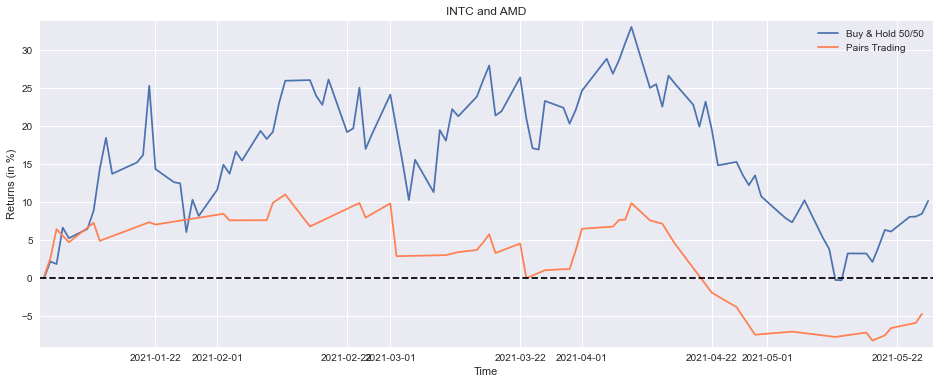

Buy & Hold 50/50 YTD Performance (at 1 July 2020) = 10.1 %
Strategy YTD Performance = -4.8 %


In [114]:
BuyHoldBothYTD = (((df1.loc[subset]['Adj Close']/df1.loc[subset]['Adj Close'].iloc[0]-1)))+((df2.loc[subset]['Adj Close']/df2.loc[subset]['Adj Close'].iloc[0]-1)/2).fillna(method='ffill')

StrategyYTD = returns.loc[returns_ytd_slice].cumsum()

plt.figure(figsize=(16,6))
plt.plot(BuyHoldBothYTD*100, label='Buy & Hold 50/50')
plt.plot(StrategyYTD*100, label='Pairs Trading', color='coral')
plt.title(" and ".join(tickers))
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')